In [3]:
# Code borrowed from
# https://www.kaggle.com/gzuidhof/full-preprocessing-tutorial/notebook

import numpy as np
from scipy.ndimage.interpolation import zoom


def get_pixels_hu(slices):
    """Takes in a list of dicom datasets and returns the 3D pixel
    array in Hounsfield scale, taking slope and intercept into
    account.
    """
    for s in slices:
        assert s.Rows == 512
        assert s.Columns == 512

    image = np.stack([np.frombuffer(s.pixel_array, np.int16).reshape(512, 512)
                      for s in slices])

    # Convert the pixels Hounsfield units (HU)
    for i, s in enumerate(slices):
        intercept = s.RescaleIntercept
        assert intercept == -1024
        slope = s.RescaleSlope
        assert slope == 1
        image[i] += np.int16(intercept)

    # Some scans use -2000 as the default value for pixels not in the body
    # We set these pixels to -1000, the HU for air
    image[image == -1024 - 2000] = -1000

    return image


def standardize_spacing(image, slices):
    """Takes in a 3D image and interpolates the image so
    each pixel corresponds to approximately a 1x1x1 box.
    """
    # Determine current pixel spacing
    spacing = np.array(
        [slices[0].SliceThickness] + list(slices[0].PixelSpacing),
        dtype=np.float32
    )
    new_shape = np.round(image.shape * spacing)
    resize_factor = new_shape / image.shape

    return zoom(image, resize_factor, mode='nearest')


def mip_array(array: np.ndarray, type: str) -> np.ndarray:
    print(np.max(array, axis=0).shape)
    return np.max(array, axis=0)


def crop(arr: np.ndarray, whence: str):
    if whence == 'numpy':
        to_return = arr[len(arr)-35-64:len(arr)-35]
    else:
        to_return = arr[len(arr)-40:]
    return to_return


def remove_extremes(arr: np.ndarray):
    a = arr > 270
    b = arr < 0
    arr[a] = -50
    arr[b] = -50
    return arr


def normalize(image, lower_bound=None, upper_bound=None):
    if lower_bound is None:
        lower_bound = image.min()
    if upper_bound is None:
        upper_bound = image.max()

    image[image > upper_bound] = upper_bound
    image[image < lower_bound] = lower_bound

    return (image - image.mean()) / image.std()


In [12]:
import os
import csv
import random
import numpy as np
from scipy.ndimage.interpolation import zoom
from keras.preprocessing.image import ImageDataGenerator

from google.cloud import storage



BLACKLIST = ['LAUIHISOEZIM5ILF',
             '2018050121043822',
             '2018050120260258',
            ]


class MipGenerator(object):

    def __init__(self, dims=(120, 120, 1), batch_size=16,
                 shuffle=True,
                 validation=False,
                 split=0.2, extend_dims=True,
                 augment_data=True):
        self.dims = dims
        self.batch_size = batch_size
        self.extend_dims = extend_dims
        self.augment_data = augment_data
        self.validation = validation

        self.datagen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.1,
            height_shift_range=0.1,
            zoom_range=0.1,
            horizontal_flip=True
        )

        # Delete all content in tmp/npy/
        filelist = [f for f in os.listdir('/home/amy/data/amy1/tmp/npy')]
        for f in filelist:
            os.remove(os.path.join('/home/amy/data/amy1/tmp/npy', f))

        # Get npy files from Google Cloud Storage
        gcs_client = storage.Client.from_service_account_json(
            '/home/amy/data/amy1/client_secret.json'
        )
        bucket = gcs_client.get_bucket('elvos')
        blobs = bucket.list_blobs(prefix='multichannel_mip_data/from_numpy/')

        files = []
        for blob in blobs:
            file = blob.name

            # Check blacklist
            blacklisted = False
            for each in BLACKLIST:
                if each in file:
                    blacklisted = True

            if not blacklisted:
                # Add all data augmentation methods
                files.append({
                    "name": file,
                })

                if self.augment_data and not self.validation:
                    self.__add_augmented(files, file)

        # Split based on validation
        if validation:
            files = files[:int(len(files) * split)]
        else:
            files = files[int(len(files) * split):]

        # Get label data from Google Cloud Storage
        blob = storage.Blob('labels.csv', bucket)
        blob.download_to_filename('/home/amy/data/amy1/tmp/labels.csv')
        label_data = {}
        with open('/home/amy/data/amy1/tmp/labels.csv', 'r') as pos_file:
            reader = csv.reader(pos_file, delimiter=',')
            for row in reader:
                if row[0] != 'patient_id':
                    label_data[row[0]] = int(row[1])

        labels = np.zeros(len(files))
        for i, file in enumerate(files):
            filename = file['name']
            filename = filename.split('/')[-1]
            filename = filename.split('.')[0]
            filename = filename.split('_')[0]
            labels[i] = label_data[filename]

        # Take into account shuffling
        if shuffle:
            tmp = list(zip(files, labels))
            random.shuffle(tmp)
            files, labels = zip(*tmp)
            labels = np.array(labels)

        self.files = files
        self.labels = labels
        self.bucket = bucket

    def __add_augmented(self, files, file):
        for i in range(1):
            files.append({
                "name": file,
            })

    def generate(self):
        steps = self.get_steps_per_epoch()
        while True:
            for i in range(steps):
                print(i)
                x, y = self.__data_generation(i)
                yield x, y

    def get_steps_per_epoch(self):
        return len(self.files) // self.batch_size

    def __data_generation(self, i):
        bsz = self.batch_size
        files = self.files[i * bsz:(i + 1) * bsz]
        labels = self.labels[i * bsz:(i + 1) * bsz]
        images = []

        # Download files to tmp/npy/
        for i, file in enumerate(files):
            blob = self.bucket.get_blob(file['name'])
            file_id = file['name'].split('/')[-1]
            file_id = file_id.split('.')[0]
            blob.download_to_filename(
                '/home/amy/data/amy1/tmp/npy/{}.npy'.format(file_id)
            )
            img = np.load('/home/amy/data/amy1/tmp/npy/{}.npy'.format(file_id))
            os.remove('/home/amy/data/amy1/tmp/npy/{}.npy'.format(file_id))
            img = self.__transform_images(img)
            # print(np.shape(img))
            images.append(img)
        images = np.array(images)
        print("Loaded entire batch.")
        print(np.shape(images))
        return images, labels

    def __transform_images(self, image):
        image = np.moveaxis(image, 0, -1)

        # Set bounds
        image[image < -40] = -40
        image[image > 400] = 400

        # Normalize image and expand dims
        image = normalize(image)
        if self.extend_dims:
            if len(self.dims) == 2:
                image = np.expand_dims(image, axis=-1)
            else:
                image = np.repeat(image[:, :, np.newaxis],
                                  self.dims[2], axis=2)

        # Data augmentation methods
        if self.augment_data and not self.validation:
            image = self.datagen.random_transform(image)

        # Interpolate axis to reduce to specified dimensions
        dims = np.shape(image)
        image = zoom(image, (self.dims[0] / dims[0],
                             self.dims[1] / dims[1],
                             1))
        return image


0
Loaded entire batch.
(4, 220, 220, 3)
1
Loaded entire batch.
(4, 220, 220, 3)
2
Loaded entire batch.
(4, 220, 220, 3)
3
Loaded entire batch.
(4, 220, 220, 3)
4
Loaded entire batch.
(4, 220, 220, 3)
5
Loaded entire batch.
(4, 220, 220, 3)
6
Loaded entire batch.
(4, 220, 220, 3)
7
Loaded entire batch.
(4, 220, 220, 3)
8
Loaded entire batch.
(4, 220, 220, 3)
9
Loaded entire batch.
(4, 220, 220, 3)
10
Loaded entire batch.
(4, 220, 220, 3)
11/43 [======>.......................] - ETA: 1:46Loaded entire batch.
(4, 220, 220, 3)
12
12/43 [=======>......................] - ETA: 1:36

/home/amy/elvo-analysis/venv/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Loaded entire batch.
(4, 220, 220, 3)
13
13/43 [========>.....................] - ETA: 1:28Loaded entire batch.
(4, 220, 220, 3)
14
14/43 [========>.....................] - ETA: 1:22Loaded entire batch.
(4, 220, 220, 3)
15
15/43 [=========>....................] - ETA: 1:16Loaded entire batch.
(4, 220, 220, 3)
16
16/43 [==========>...................] - ETA: 1:11Loaded entire batch.
(4, 220, 220, 3)
17
17/43 [==========>...................] - ETA: 1:06Loaded entire batch.
(4, 220, 220, 3)
18
18/43 [===========>..................] - ETA: 1:01Loaded entire batch.
(4, 220, 220, 3)
19
19/43 [============>.................] - ETA: 57s Loaded entire batch.
(4, 220, 220, 3)
20
20/43 [============>.................] - ETA: 53sLoaded entire batch.
(4, 220, 220, 3)
21
21/43 [=============>................] - ETA: 50sLoaded entire batch.
(4, 220, 220, 3)
22
22/43 [==============>...............] - ETA: 46sLoaded entire batch.
(4, 220, 220, 3)
23
23/43 [===============>..............] - ETA: 43sLoa

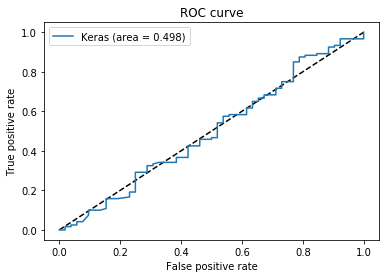

In [13]:
from keras import backend as K
from keras.models import Model, load_model
from keras.applications.resnet50 import ResNet50
import keras.metrics as metrics
from keras.layers import Average, Input
import numpy as np

from sklearn.metrics import roc_curve, auc, classification_report
import matplotlib.pyplot as plt


def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())


def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())


metrics.sensitivity = sensitivity
metrics.specificity = specificity


def ensemble(models, model_input):
    outputs = [model(model_input) for model in models]
    y = Average()(outputs)
    model = Model(model_input, y, name='ensemble')
    return model


def get_pred():
    model_base = ResNet50(weights='imagenet', include_top=False)
    model_1 = load_model('../sandbox/stage_1_resnet_v7_keep')
    model_1 = Model(inputs=model_base.input,
                    outputs=model_1(model_base.output))
    model_2 = load_model('../sandbox/stage_1_resnet_v8_hold')
    model_2 = Model(inputs=model_base.input,
                    outputs=model_2(model_base.output))
    model_3 = load_model('../sandbox/stage_1_resnet_v9_keep')
    model_3 = Model(inputs=model_base.input,
                    outputs=model_3(model_base.output))

    models = [model_1, model_2, model_3]
    model_input = Input(shape=(220, 220, 3))
    ensembleModel = ensemble(models, model_input)
    ensembleModel.compile(optimizer='adam',
                          loss='binary_crossentropy',
                          metrics=['accuracy'])

    gen = MipGenerator(
        dims=(220, 220, 3),
        batch_size=4,
        augment_data=False,
        extend_dims=False,
        validation=True,
        #split_test=True,
        shuffle=True,
        split=0.2
    )

    result = ensembleModel.evaluate_generator(
        generator=gen.generate(),
        steps=gen.get_steps_per_epoch(),
        verbose=1
    )
    print(result)

    result = ensembleModel.predict_generator(
        generator=gen.generate(),
        steps=gen.get_steps_per_epoch(),
        verbose=1
    ).ravel()

    np.save('../sandbox/pred.npy', result)


def get_validation():
    gen = MipGenerator(
        dims=(220, 220, 3),
        batch_size=4,
        augment_data=False,
        extend_dims=False,
        validation=True,
        #split_test=True,
        shuffle=True,
        split=0.2
    )

    result = []
    generate = gen.generate()
    print(gen.get_steps_per_epoch())
    for i in range(gen.get_steps_per_epoch()):
        data, labels = next(generate)
        result.append(labels)
    result = np.array(result).ravel()
    np.save('../sandbox/val.npy', result)


def sensitivity_2(y_true, y_pred):
    true_positives = np.sum(np.round(np.clip(y_true * y_pred, 0, 1)))
    possible_positives = np.sum(np.round(np.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + 1e-07)


def specificity_2(y_true, y_pred):
    true_negatives = np.sum(np.round(np.clip((1 - y_true) *
                                             (1 - y_pred), 0, 1)))
    possible_negatives = np.sum(np.round(np.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + 1e-07)


def get_auc():
    true_data = np.load('../sandbox/val.npy')
    pred_data = np.load('../sandbox/pred.npy')
    fpr_keras, tpr_keras, thresholds_keras = roc_curve(true_data, pred_data)
    auc_keras = auc(fpr_keras, tpr_keras)
    print(sensitivity_2(true_data, pred_data))
    print(specificity_2(true_data, pred_data))
    target_names = ['No', 'Yes']
    report = classification_report(true_data,
                                   np.where(pred_data > 0.5, 1.0, 0.0),
                                   target_names=target_names)
    print(report)
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_keras, tpr_keras,
             label='Keras (area = {:.3f})'.format(auc_keras))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()


get_pred()
get_validation()
get_auc()